In [1]:
%matplotlib inline

# Création de données synthétiques

In [2]:
import pointprocesses as ppr
import itertools
import numpy as np
import matplotlib.pyplot as plt

Le processus de Hawkes à noyau exponentiel est modélisé par
$$
    g(t) = \alpha\beta e^{-\beta t}
$$

In [3]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [4]:
T = 60.0
alpha = 0.2
beta  = 0.9
lam0  = 1.0

In [5]:
print("Avg. no. of events: %.3f" % (T*lam0/(1-alpha)))

Avg. no. of events: 75.000


73


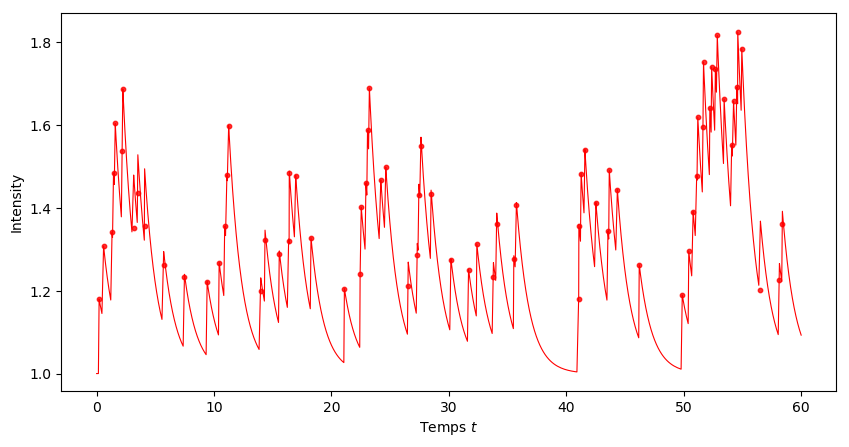

In [6]:
data = ppr.hawkes_exp(T, beta, lam0, itertools.repeat(alpha))
print(data[:,0].size)

time_vals = np.sort(np.append(np.linspace(0, T, 400), data[:,0]))

ints_proc = intensity_function(time_vals, lam0, alpha, beta, data[:,0])

fig, ax = plt.subplots(1, 1, figsize=(10,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel("Intensity")
ax.scatter(data[:,0], data[:,1], c='r', s=10, alpha=0.8)
ax.plot(time_vals, ints_proc, 'r-', linewidth=0.8)

# Network design

On utilisera PyTorch pour réaliser notre réseau de neurones récursif (RNN).

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as tnf

In [8]:
x = torch.rand(5, 3)

In [9]:
print(x)

tensor([[0.7917, 0.1021, 0.5094],
        [0.3781, 0.8806, 0.3575],
        [0.4914, 0.2648, 0.9196],
        [0.7383, 0.6977, 0.9785],
        [0.4339, 0.6076, 0.4560]])


### Basic RNN

Algorithme d'Ogata pour le calcul récursif de la fonction d'intensité $\lambda$:
$$
    \lambda_k = \lambda_0 + e^{-\beta(t_k-t_{k-1})}(\lambda_{k-1} - \lambda_0) + \alpha\beta \xi_k
$$
où $\xi_k = \xi(t_k)$ vaut 1 ssi il s'est produit un événement en $t_k$ et 0 sinon.

La probabilité qu'un événement se produise entre $t_{k-1}$ et $\Delta t$:
$$
    \mathbb P(t_k\in[t_{k-1}, t_{k-1} + \Delta t], \xi_k = 1\mid \mathcal H_{k-1}) = 1 - \exp\left(-(\lambda_{k-1} - \lambda_0)\left(\frac{1 - e^{-\beta\Delta t}}{\beta}\right) - \lambda_0\Delta t\right) := \mathcal L_k(\Delta t)
$$

En effet, $t_k$ suit conditionnellement une loi exponentielle de paramètre
$$
    \Lambda = \int_{t_{k-1}}^{t_k} \lambda_s\,\mathrm ds.
$$
et on peut utiliser la formule d'Ogata (qui est exacte) pour exprimer $\lambda_s$, le terme en $\xi(s)$ étant d'intégrale nulle.

On cherche le meilleur estimateur $\beta \in \{\beta_1,\ldots,\beta_p\}$ parmi des valeurs discrètes.

On peut utiliser un algorithme d'_inférence bayésienne_:
$$
    \mathbb P(\beta_j\mid \mathcal H_k) \sim \sum_{\xi_k\in\{0,1\}}\mathbb P(\xi_k, t_k\mid \mathcal H_{k-1},\beta_j) \mathbb P(\beta_j, \mathcal H_{k-1})
$$

où 
$$
    \mathbb P(\xi_k, t_k\mid \mathcal H_{k-1},\beta_j) = \mathcal L_k^{(j)}(t_k - t_{k-1})\left(\lambda_0 + e^{-\beta_j(t_k - t_{k-1})}(\lambda_k^{(j)} - \lambda_0) \right)^{\xi_k}
$$
avec l'indice $(j)$ précisant que les valeurs sont calculées pour $\beta = \beta_j$.

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, mu, betas):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.mu = mu
        self.betas = betas
        
        self.fch = nn.Linear(input_size + hidden_size, hidden_size)
        self.fco = nn.Linear(input_size + hidden_size, output_size)
    
    def forward(self, t, hidden):
        concat = torch.cat((t, hidden))
        output = self.fch(concat)
        hidden = self.fco(concat)
        return output, hidden
    
    def likelihood(self, dt):
        """
        Compute the likelihoods of the next event happening within dt.
        """
        exponent = (self.intens - self.mu)*(1 - (-self.betas*dt).exp()/betas + self.mu*dt
        return 1 - (-exponent).exp()